In [29]:
import altair as alt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

from dsci_310_group_11_pkg.preprocess import preprocessor
from dsci_310_group_11_pkg.pipeline import pipe_build
from dsci_310_group_11_pkg.optimize import hp_optimizer 
# from dsci_310_group_11_pkg.grapher import correlation_table
# from dsci_310_group_11_pkg.grapher import bar_chart
# from dsci_310_group_11_pkg.grapher import class_report, vis_tree, show_coefficients, show_correct, compare_scores

# from src.pipeline import pipe_build
# from src.optimize import hp_optimizer
# from src.preprocess import preprocessor
from src.grapher import correlation_table, bar_chart, vis_tree, compare_scores, show_coefficients, show_correct

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Introduction

As one of the most popular drinks in the world,  wine has historically and continues to hold an important role in society. According to Ritchie and Roser, the consumption of wine is growing significantly since 1960.  Specifically, Canadian on average consumed  0.3 liters of wine in 1964, and the consumption grows to 2.1 liters of wine in 2019 [@Ritchie2018]. As the demand of wine grows rapidly, more and more wine companies begin to focus on improve the wine quality in order to attracts consumers and make more profit. However, due to complexity of wine production process, a sophisticated  way to predict wine quality is still rare. Furthermore, recent research done by Filipe-Ribeiro et. al suggested that certain chemical ingredients are found correlated to wine quality [-@Filipe-Ribeiro2017]. **Therefore, this project will examine the relationship between chemical ingredients and the quality of wine, and attempt to answer the question of whether wine can be classified as 'good' or 'bad' based on its chemical ingredients.** 

This project will use the red wine dataset collected from UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/wine+quality). This dataset contains 1599 observations, and 12 variables shown as follow:  

>1 - fixed acidity
<br>2 - volatile acidity<br>3 - citric acid<br>4 - residual sugar
<br>5 - chlorides
<br>6 - free sulfur dioxide
<br>7 - total sulfur dioxide
<br>8 - density
<br>9 - pH
<br>10 - sulphates
<br>11 - alcohol
<br>12 - quality (score between 0 and 10)

For this project, wine quality will be used as the target variable.

## Preliminary EDA

In [2]:
# UCI Machine Learning Database
df = pd.read_csv('data/winequality-red.csv', sep=',')

In [3]:
#| label: tbl-datapreview
#| tbl-cap: First five rows of the UCI Wine Dataset
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


After loading in the data set from the UCI Machine Learning Database @tbl-datapreview, we first visualize the distribution @fig-barchart of wine qualities via histogram. Viewing the distribution will affect where the split in our data occurs.

In [30]:
bar_chart(df)

alt.Chart(...)

**Judging from @fig-barchart, we have a right-skewed distribution with a mode at quality = 5. Therefore, we should classify 'good' wines as any wine rated at 6, 7 or 8. Consequently, 'bad' wines will be rated at 3, 4, and 5.**

We then visualize the correlation grid between all of our feature variables. This assists to identify patterns and relationships between the variables, allowing us to gain insights into the underlying structure of the data and potentially identify features that are highly correlated with the target variable. This can help us to better understand the data and inform our feature selection and model building decisions.

In [31]:
correlation_table(df)

alt.Chart(...)

From @fig-corrtab, we can see that acids, densities, and sulfur dioxides tend to rise together, whereas acid and pH levels posess an inverse relationship. Furthermore, the 'quality' rating variable has the highest correlation with alcohol content - and the highest negative correlation with volatile acidity.

This correlation grid is based off of un-scaled values which may unfairly adjust the coefficients of these relationships. We will explore these coefficients properly in the 'Methods' section.

# Methods

#### **Overview of Methodology**

In machine learning, model selection plays a critical role in achieving the best performance on a given task. As our task involves classifying wines as 'good' or 'bad' based on their chemical properties, we will proceed with the four classification models to predict the outcomes of our wine data set. to predict the outcomes of our wine dataset: 

- Logistic Regression
- Decision Tree
- Naive Bayes
- SVM with RBF kernel 

The outcomes of these models (i.e. each model's accuracy in classification) will assist us in determining whether our 11 feature values (subtracting the 'quality' metric) can be accurate predictors for classifying wines as 'good' or 'bad', or if there are other factors at play. A baseline model will also be included as a point of comparison for all the other machine learning models used.

In our quality classification, the input features are chemical composition of wine samples: such as alcohol content, fixed acidity, chlorides, sulphates, etc. The output label is derived from the *quality* rating assigned to each wine sample (sourced from various wine critics). If the quality score greater than 5, it is classified as 'good' - whereas below 5 results in a 'bad' classification.

Additionally, we split the data into separate train (0.80) and test set (0.20) to help us evaluate the performance of a model. We utilize the training data to expose the model to the dataset, and test the model's ability to predict the 'target' value of our test data. This provides an estimate of how well the model will generalize to data that we have not seen yet.

In [6]:
# The integer specifies to return the train or test dataframe
train_df = preprocessor(df, 0)
test_df = preprocessor(df, 1)

Checking for class imbalance in our dataset @tbl-valuecounts is essential before doing classification because it affects the performance of classification algorithms. If the dataset is imbalanced, where one class has significantly more or fewer samples than the other, the algorithm may have a bias towards the majority class, leading to poor performance on the minority class.

In [7]:
# Splitting into X and y train and test sets
X_train = train_df.drop(columns=["target", "quality"])
y_train = train_df["target"]

X_test = test_df.drop(columns=["target", "quality"])
y_test = test_df["target"]

In [8]:
#| label: tbl-valuecounts
#| tbl-cap: Class counts (positive = 1, negative = 0)
# Checking for class imbalance
train_df["target"].value_counts().to_frame()

,count
target,
1,607
0,512


As the ratio between positive classes (good - 1) and negative classes (bad - 0), our training set has an adequate level of class balance, so re-balancing is unnecessary. We then separate our train and test sets into 'X' (inputs) and 'y' (outputs). We will then use our 'X' variables to train our model to predict the correct 'y' value.

#### Baseline Model

To start, we will be using sklearn's DummyClassifier() to make a baseline model. The model will simply predict every instance as the most commonly occurring target value. In this case, it will predict the target value of every instance to be 1.

In [9]:
base = pipe_build('dummy', X_train, y_train)
base_score = base.score(X_test, y_test)

/Users/justin/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justin/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justin/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


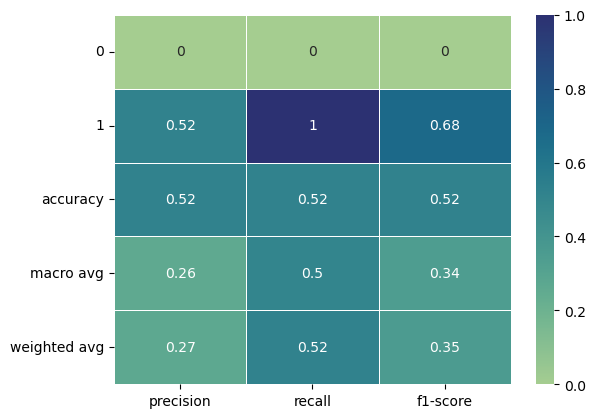

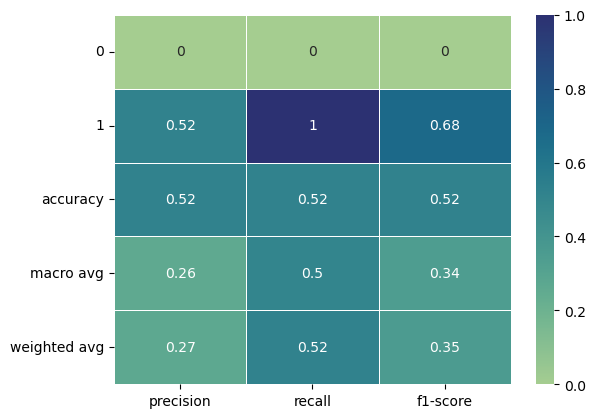

In [10]:
class_report(base, X_test, y_test)

The classification report in @fig-dummyreport shows that the baseline model generates an accuracy score of 0.53, as long as the accuracy of the following models give an accuracy score of greater than 0.53, they will be performing better than a baseline model that essentially guesses at random.

In [11]:
#| label: tbl-dumcounts
#| tbl-cap: Baseline model class counts (positive = 1, negative = 0)

# Displays how many TP/TN we received versus FP/FN
show_correct(base, X_test, y_test).to_frame(name='Positive vs. Negative')

,Positive vs. Negative
correct,
True,248
False,232


@tbl-dumcounts displays how many guesses our classifier got right (true positive/true negative classifications) versus how many it got wrong (false positives/false negative classifications). As you can see, the dummy classifier was only able to classify 248 wine samples correctly, while 232 wine samples were classified incorrectly on the test set.

#### Logistic Regression

*For report simplicity: the methods section of our Logistic Regression will go into detail for each step, whereas our remaining models will provide explanations for additional steps that were not performed in Logistic Regression.*




LogisticRegression() is an sklearn algorithm that models the probability of a binary output label given a set of input features. Given a set of $n$ input examples, each with $m$ features, the goal of logistic regression is to learn a set of weights $\mathbf{w} = [w_0, w_1, ..., w_m]$ that can be used to predict the probability of a binary outcome $y$ (where $y \in {0, 1}$) for any input example $\mathbf{x} = [x_1, x_2, ..., x_m]$. The logistic regression model uses a sigmoid function to map the output of the linear regression model to a probability between 0 and 1. The sigmoid function is defined as:

\begin{equation}
\sigma(z) = \frac{1}{1 + e^{-z}}
\end{equation}

where $z$ is the output of the linear regression model:

\begin{equation}
z = w_0 + w_1 x_1 + w_2 x_2 + ... + w_m x_m
\end{equation}

The output of the logistic regression model is then given by:

\begin{equation}
\hat{y} = \sigma(z)
\end{equation}

where $\hat{y}$ is the predicted probability of the binary outcome $y$.

**In our wine quality classification, we use logistic regression to classify wines as either good (positive class) or bad (negative class) based on their chemical properties. We will use a dataset containing $1599$ examples of wines, each with $12$ features.The result of the logistic function will classify our wine as 'good' or 'bad'.**

##### Hyperparameter Optimization

Hyperparameter optimization is the process of finding the optimal values for the 'knobs' of an algorithm. Properly tuning these hyperparameters help us improve the performance of the model - therefore, we will perform this same optimization on all four of our models. 

For the case of our logistic regression is the regularization parameter 'C'. The regularization parameter 'C' controls the amount of regularization applied to the model, and it helps prevent overfitting by adding a penalty to incorrect classifications. We generated a range of potential values (@tbl-lrhp) of C between 0.0001 and 100000 and measured their mean cross_validation scores.

In [12]:
#| label: tbl-lrhp
#| tbl-cap: Logistic Regression 'C' Optimization

lr_df = hp_optimizer('lr', X_train, y_train)
lr_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.542449,0.542449
1,0.0010,0.722519,0.717605
2,0.0100,0.761173,0.755165
3,0.1000,0.761842,0.746228
4,1.0000,0.761172,0.753375
5,10.0000,0.762289,0.753375
6,100.0000,0.762513,0.753375
7,1000.0000,0.762513,0.753375
8,10000.0000,0.762513,0.753375
9,100000.0000,0.762513,0.753375


Based on our mean cross-validation scores for each possible value of C, we will choose C = 10.

##### Applying the LogisticRegression Classifier

Before we proceed with building the LogisticRegression model, we scale our data before applying a LogisticRegression model to ensure that all the features have the same importance in the model. LogisticRegression assumes that the features are normally distributed and are on the same scale. Thus, failure to scale our data beforehand may lead to some features may dominate the others in the model.

Scaling the data also assists in interpreting the coefficients of the model. The coefficients represent the effect of each feature on the target variable, and scaling the features ensures that the coefficients are comparable and meaningful. For example, if the features are on different scales, then the coefficients cannot be compared directly, and their magnitudes do not reflect the actual effect of the features on the target variable.

To do this, we instantiate a pipeline object that applies prerequisite scaling, and then fits the training data to our Logistic Regression model.

In [13]:
# Scaling and applying LogisticRegression model to our data
pipe = pipe_build('lr', X_train, y_train)
lr_score = pipe.score(X_test, y_test)

In [14]:
#| label: tbl-lrcoefs
#| tbl-cap: Logistic Regression Feature Coefficients

# Show the coefficients of each feature
show_coefficients(pipe, X_train)

,features,coefficients
10,alcohol,0.557171
9,sulphates,0.294993
0,fixed acidity,0.078786
3,residual sugar,0.053544
2,citric acid,0.047082
8,pH,0.030836
5,free sulfur dioxide,0.006978
4,chlorides,-0.159880
7,density,-0.180240
6,total sulfur dioxide,-0.290319


As visible from @tbl-lrcoefs, the variables with most influence per unit are volatile acidity and alcohol. Volatile acidity has a negative relationship with quality whereas alcohol has a positive relationship with quality.

In [15]:
#| label: tbl-lrpreds
#| tbl-cap: Logistic Regression prediction results

# Displays how many TP/TN we received versus FP/FN
show_correct(pipe, X_test, y_test).to_frame(name='Positive vs. Negative')

,Positive vs. Negative
correct,
True,347
False,133


Our model has produced an accuracy score of 73%; correctly classifying 73% of the test dataset's wine samples as either 'good' or 'bad', indicating a moderate level of predictive power. Furthermore, comparing this metric to our baseline model's accuracy of 53% - it is clear that the regression model is succeeding in some capacity. We can see the exact numbers of how many data points were correctly classified versus not correctly classified above @tbl-lrpreds.

However, it is important to note that the accuracy score alone may not be sufficient to evaluate the performance of the model. Therefore, we produce a classification report (@fig-lrreport) containing precision, recall, and F1-score in order to get a better understanding of the model's strengths and weaknesses.

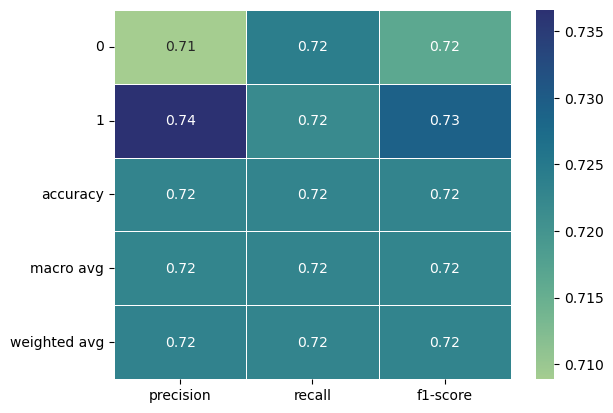

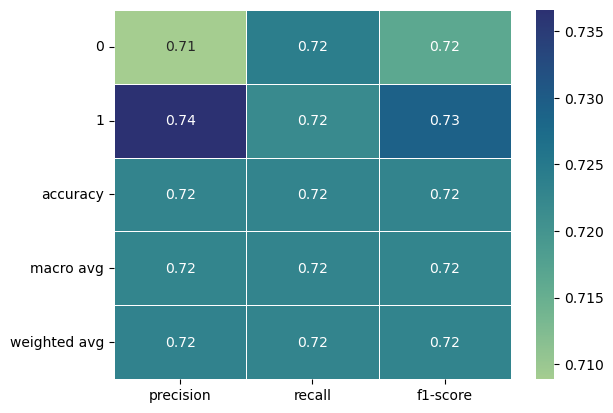

In [16]:
class_report(pipe, X_test, y_test)

#### SVC RBF

SVM RBF fits a decision boundary that separates the positive and negative classes with the largest margin. The decision boundary is represented as a hyperplane in a high-dimensional feature space, and the RBF kernel is used to compute the distance between input examples and the decision boundary.

The function is defined as:

\begin{equation}
K(\mathbf{x}_i, \mathbf{x}_j) = e^{-\gamma ||\mathbf{x}_i - \mathbf{x}_j||^2}
\end{equation}

where $\mathbf{x}_i$ and $\mathbf{x}_j$ are input examples, and $\gamma$ is a hyperparameter that controls the shape of the kernel function.

**SVM RBF (Support Vector Machine with Radial Basis Function) Classification may be an effective choice for our model due to its ability to model complex decision boundaries and capture non-linearity in the data. As our dataset contains 11 different features with possibly different relationships with our 'target' variable, utilizing SVM RBF may result in a better accuracy score than Logistic Regression.**

In [17]:
# Instantiate the pipeline with a scaler and the SVM RBF Classifier
pipe_svm = pipe_build('svm', X_train, y_train)
svm_score = pipe_svm.score(X_test, y_test)

##### Hyperparameter Optimization

In [18]:
#| label: tbl-svmhp
#| tbl-cap: SVM RBF Hyperparameter Optimization

hp_optimizer('svm', X_train, y_train)

,C,gamma,mean_cv_score
0,0.001,0.001,0.525408
1,0.010,0.001,0.525408
2,0.100,0.001,0.489694
3,1.000,0.001,0.720303
4,10.000,0.001,0.733712
5,100.000,0.001,0.743546
6,0.001,0.010,0.525408
7,0.010,0.010,0.525408
8,0.100,0.010,0.717621
9,1.000,0.010,0.737284


We perform the same hyperparameter optimization we applied to our LogisticRegression model but we tune an additional hyperparameter for our SVM RBF model (@tbl-svmhp): gamma. This hyperparameter controls the shape of the decision boundary (which we will visualize later), adding complexity by raising its value.

After optimizing hyperparameters, we fit and score the model similarly to our LogisticRegession process.

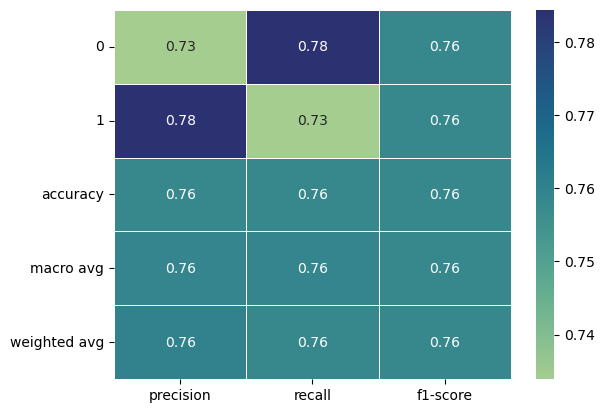

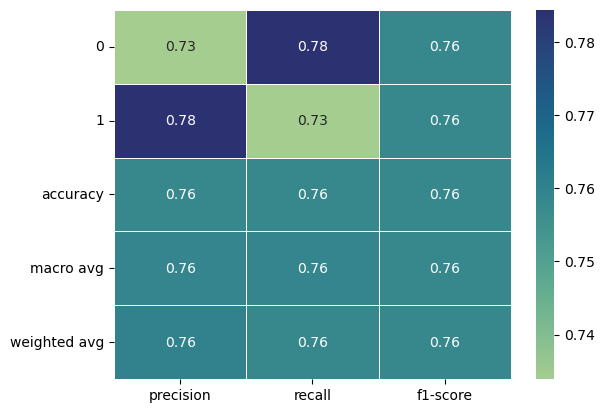

In [19]:
class_report(pipe_svm, X_test, y_test)

Utilizing SVM RBF led to a slightly higher accuracy score of 76% (@tbl-svmreport)compared to our original Logistic Regression model, which suggests the model is marginally more confident when predicting 'good' and 'bad' wine. Both of these models performed significantly better than our baseline model.

In [20]:
#| label: tbl-svmreport
#| tbl-cap: SVM RBF prediction results

# Displays how many TP/TN we received versus FP/FN
show_correct(pipe_svm, X_test, y_test).to_frame(name='Positive vs. Negative')

,Positive vs. Negative
correct,
True,364
False,116


#### Decision Tree Classifier

When deciding between tree-model classifications, the two obvious options are **Decision Trees** and **Random Forest** classifiers. While Random Forest Classifiers are more complex and may achieve higher accuracy scores on large datasets, it may not be the best option for small datasets. Random Forest requires a large number of samples and features to achieve good performance. With a small dataset like our wine set, Random Forest may overfit the training data and fail to generalize well on unseen data. Moreover, the computational cost of training and testing a Random Forest can be much higher than a simple Decision Tree, especially with limited computational resources.

Therefore, we chose a **Decision Tree Classifier** because of its easy interpretability and computational efficiency.

In our wine classification, we use an algorithm that chooses which chemical splits the dataset with the lowest impurity (in laymen's terms: the ratio between correct and incorrect classes) at each step. We will use the Gini index as a measure of impurity, which is defined as:

\begin{equation}
Gini(D) = 1 - \sum_{i=1}^k p_i^2
\end{equation}

where $D$ is a set of training examples, $k$ is the number of classes, and $p_i$ is the proportion of examples in class $i$.

The algorithm continues recursively until a stopping criterion is met, such as when all examples in a subset belong to the same class, or when a maximum tree depth or minimum number of examples per leaf is reached. We will run cross-validation to optimize the maximum tree depth hyperparameter.

In [21]:
pipe_dtc = pipe_build('dtc', X_train, y_train)
dtc_score = pipe_dtc.score(X_test, y_test)

##### Hyperparameter Optimization

In [22]:
#| label: tbl-dtchp
#| tbl-cap: Decision Tree 'Max Depth' Optimization

hp_optimizer('dtc', X_train, y_train)

,max_depth,mean_cv_score
0,1,0.722057
1,3,0.736359
2,5,0.741724
3,7,0.747990
4,9,0.751557
5,11,0.743510
6,13,0.746188
7,15,0.750653
8,17,0.741720
9,19,0.742605


##### Fitting and representing the decision tree

According to our hyperparameter optimization (@tbl-dtchp), max_depth = 7 is producing the best classification model. For representation purposes (@fig-dtctree) is a decision tree with max_depth = 3 (plotting high max_depths is visually terrifying) that displays the first three decision parameters being used in our classifier. Alcohol, volatile acidity, total/free sulfur dioxide, and sulphates are our participating features. **However, the gini impurity of each node is alarming - which could suggest that the model is struggling to clearly split the dataset based on these features.**

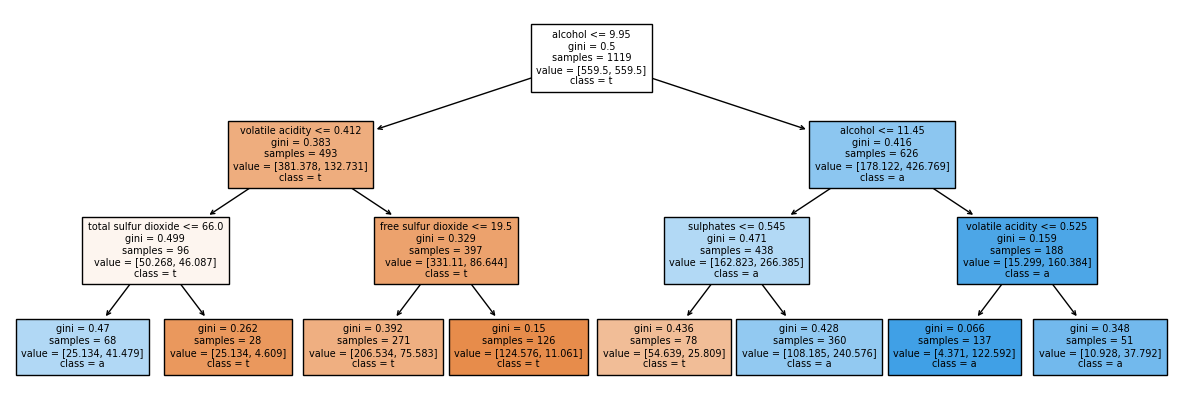

In [32]:
vis_tree(X_train, y_train)

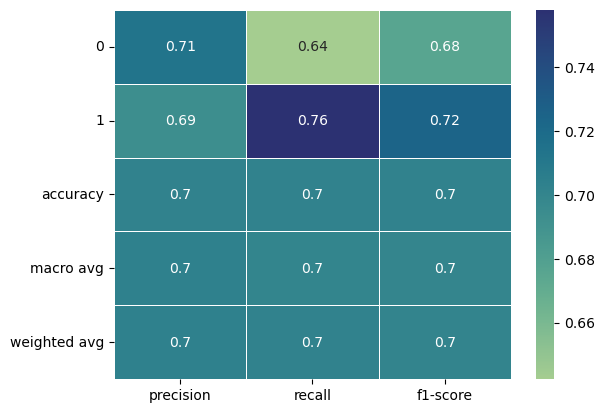

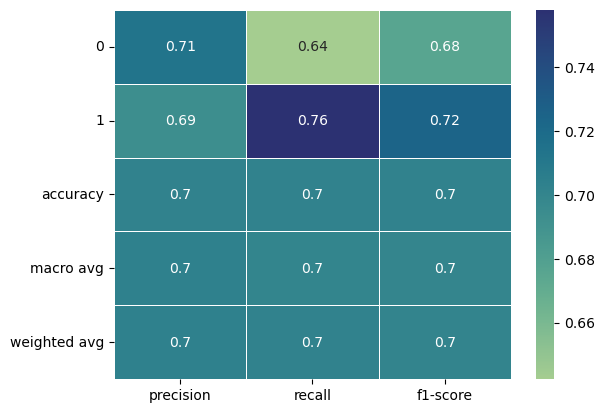

In [23]:
class_report(pipe_dtc, X_test, y_test)

Our DecisionTreeClassifier performed marginally worse than our previous two models at 0.71 accuracy (@fig-dtcreport). This may be due to decision trees being based on simple if-then rules (@fig-dtctree), and they may not be able to model complex relationships between the features and the target variable. Our other models on the other hand are generally more flexible models - handling both linear and nonlinear relationships between our features and the 'target' variable. Additionally, our decision tree may be more susceptible to noise and outliers in the data, which can lead to spurious splits in the tree and a less accurate model.

In [24]:
#| label: tbl-dtcreport
#| tbl-cap: Decision Tree prediction results

# Displays how many TP/TN we received versus FP/FN
show_correct(pipe_dtc, X_test, y_test).to_frame(name='Positive vs. Negative')

,Positive vs. Negative
correct,
True,337
False,143


#### Naive Bayes

Naive Bayes calculates the conditional probability of each class given a set of features by multiplying the probability of each feature given the class. The class with the highest probability is then assigned to the input data.

To train the model, it first calculates the prior probability of each class based on the frequency of occurrence of the class in the training data. It then calculates the conditional probability of each feature given each class by counting the number of times a feature appears in the training data for each class.

\begin{equation}
P(y \mid x_1, x_2, \dots, x_m) = \frac{P(y) P(x_1, x_2, \dots, x_m \mid y)}{P(x_1, x_2, \dots, x_m)}
\end{equation}

where $y$ is the class label, $x_1, x_2, \dots, x_m$ are the wine features, $P(y)$ is the prior probability of the class label ('good or 'bad'), and $P(x_1, x_2, \dots, x_m \mid y)$ is the likelihood of the wine features given the class label. The denominator $P(x_1, x_2, \dots, x_m)$ is a normalization constant that ensures that the probabilities sum to 1.

**Once the model is trained, it seeks to classify new wine by calculating the probability of the bottle being 'good' or 'bad' given the chemical input features and selecting the class with the highest calculated probability.**

In [25]:
# Create a Gaussian Classifier
pipe_bayes = pipe_build('bayes', X_train, y_train)
bayes_score = pipe_bayes.score(X_test, y_test)

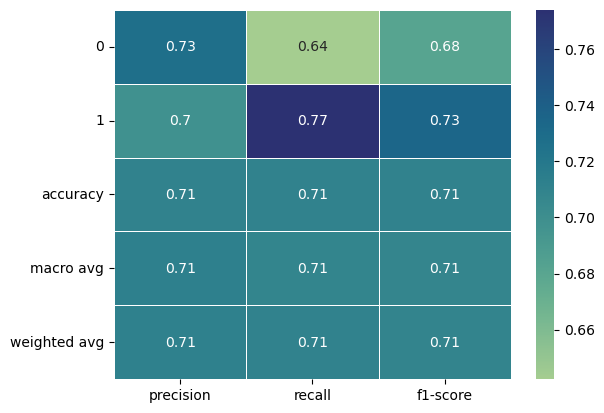

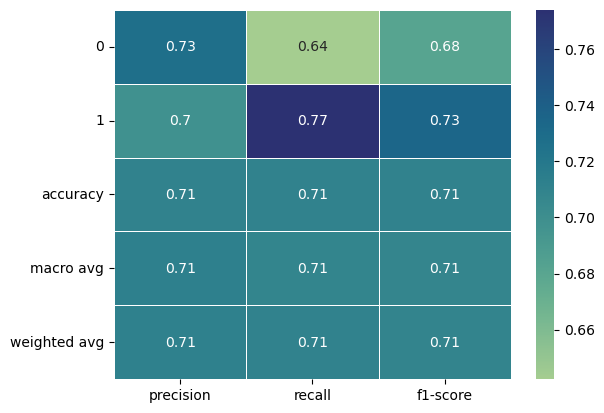

In [26]:
class_report(pipe_bayes, X_test, y_test)

Naive Bayes performed the best out of our other models at an accuracy score of 0.75 (@fig-bayesreport).

In [27]:
#| label: tbl-bayespreds
#| tbl-cap: Decision Tree prediction results

# Displays how many TP/TN we received versus FP/FN
show_correct(pipe_bayes, X_test, y_test).to_frame(name='Positive vs. Negative')

,Positive vs. Negative
correct,
True,341
False,139


In [28]:
lst = [base_score, lr_score, svm_score, dtc_score, bayes_score]
compare_scores(lst)

'{\n  "$schema": "https://vega.github.io/schema/vega-lite/v4.17.0.json",\n  "config": {\n    "background": "lightgrey",\n    "view": {\n      "continuousHeight": 300,\n      "continuousWidth": 400\n    }\n  },\n  "data": {\n    "name": "data-be3193017072a6cf1e69e0c097ce7701"\n  },\n  "datasets": {\n    "data-be3193017072a6cf1e69e0c097ce7701": [\n      {\n        "Score": 0.5166666666666667,\n        "index": "Baseline"\n      },\n      {\n        "Score": 0.7229166666666667,\n        "index": "LR"\n      },\n      {\n        "Score": 0.7583333333333333,\n        "index": "SVC"\n      },\n      {\n        "Score": 0.7020833333333333,\n        "index": "DT"\n      },\n      {\n        "Score": 0.7104166666666667,\n        "index": "NB"\n      }\n    ]\n  },\n  "encoding": {\n    "color": {\n      "condition": {\n        "test": "(datum.Score === 0.7583333333333333)",\n        "value": "red"\n      },\n      "value": "steelblue"\n    },\n    "x": {\n      "field": "Score",\n      "type": 

##### Comparing Scores

After training and testing the models, the **Naive Bayes** model achieved the highest test score accuracy score of 0.75 (@fig-scores). Furthermore, all four models performed significantly better than our 'most-frequent' baseline strategy.

# Discussion

Our trained models all performed better than the baseline model, but a best score of 0.75 is not sufficient to accurately predict wine quality based on its chemical qualities. While the lower accuracy score is not ideal, it is expected. Errors in the predictions may be due to the limitations of the methods used; however, it is likely also due to the varying preferences of the individuals surveyed to obtain the data. Limitations of the models used have been previously mentioned in the methods section, so this section will focus on human biases. The standards and qualities of wine are all determined by people and even though there may be experts that know the field, quality is still a subjective measurement and experts will still have bias in their judgments. As noted in the paper by Cortez et al, sensory evaluations and analyses are performed on the wine tasters during wine certification in Portugal; however, even then, it does not fully account for personal preferences or biases [-@Cortez2009]. As such, it is difficult to account or correct for the subjectivity of human taste. This also means that it will be difficult for an algorithm to predict the quality of wine since patterns may not always be present or clear. Therefore, a lower accuracy score is expected.

Another limitation in this method of predicting quality of wine based on chemical features is the fact that this data set only considers 11 features. In a 1978 study on wine quality, there were statistically significant correlations between the amounts of pigments in the wine and the perceived quality of the wine [@Jackson1978]. Pigments were not considered in the data set used in this project. These pigments may have some effect on the flavour but can also influence the appearance. It was not apparent whether or not the wine data was from a blind tasting or if visual indicators of quality were also considered, so there are additional factors that were not included within the analysis.

Although there are several limitations to the methods used in this project, there may still be use for machine learning algorithms within the realm of predictions of wine quality. Primarily, it could still be useful in more targeted marketing techniques or finding ideal wines for more specific consumer groups. 

# References

::: {#refs}
:::